In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import qiskit
import qiskit.quantum_info as qi 
# import warnings
# warnings.filterwarnings('ignore')
import time
import networkx as nx


In [2]:
# produce all binary strings of length n with k 1s. If k is None then all possible binary strings of length n produced
def get_binary_strings(n, k=None) -> list[list]:
    '''
    produce all binary strings of length n with k 1s
    returns list with binary lists 
    '''
    final = []
    def kbits(r):
        result = []
        for bits in itertools.combinations(range(n), r):
            s = [0] * n
            for bit in bits:
                s[bit] = 1
            result.append(s)   
        return result

    if k != None:
        return kbits(k)
    
    for i in range(n + 1):
        final = final + kbits(i)
        
    return final


In [3]:

def get_circuit_operators( lst_x=None, lst_z=None):
    '''
    note the order! (x,z)
    '''
    # returns for example X @ I @ I @ X @ I where @ is tensor product
    return  qi.Pauli((lst_z,lst_x)).to_matrix()

In [18]:
def generate_QAOA_operator(nqubits, locality, number_of_terms, number_of_layers = 1 , beta_angle = [], gamma_angle = []):
    """_summary_

    Args:
        nqubits (_type_): _description_
        locality (_type_): _description_
        number_of_terms (_type_): _description_
        number_of_layers (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """    '''

    '''

    # define angles for mixers 
    if len(beta_angle)==0:
        beta_angle = np.random.rand(number_of_layers) * np.pi
    cos_angle_beta = np.ones(number_of_layers)*np.cos(beta_angle)
    sin_angle_beta = np.ones(number_of_layers)*np.sin(beta_angle)

    if len(gamma_angle)==0:
        gamma_angle = np.random.rand(number_of_layers) * np.pi
    cos_angle_gamma = np.ones(number_of_layers)*np.cos(gamma_angle)
    sin_angle_gamma = np.ones(number_of_layers)*np.sin(gamma_angle)
 

    # making Hamiltonian 

    locality = min(locality, nqubits)
    number_of_terms = min(number_of_terms,nqubits)

    # Hamiltonian  ZjZk
    rng = np.random.default_rng()
    Zs = get_binary_strings(nqubits,locality)
    # pickedZ = np.random.choice(Zs,size=number_of_terms,replace=False)
    pickedZ = rng.choice(Zs, min(number_of_terms,len(Zs)), replace=False)
    if number_of_terms > len(Zs):
        print("Warning: less terms than possible terms")
    # Making Hamiltonian
    H = 0
    for i in range(0,len(pickedZ)):
        H = H + get_circuit_operators(np.zeros(nqubits),pickedZ[i])

    ans = H

    for p in range(number_of_layers):
        # Making unitary for Hamiltonian exp
        identity = get_circuit_operators(np.zeros(nqubits),np.zeros(nqubits))

        
        unitary_z = identity

        for i in range(0,len(pickedZ)):
            unitary_z = unitary_z@(cos_angle_beta[p]*identity \
            - 1j*sin_angle_beta[p]*get_circuit_operators(np.zeros(nqubits),pickedZ[i]))


        # Making mixer X
        x_string = np.zeros(nqubits)
        x_string[0] = 1
        unitary_x = identity

        x_string[0] = 0
        for i in range(0,nqubits):
            x_string[i] = 1
            unitary_x = unitary_x@(cos_angle_gamma[p]*identity \
            - 1j*sin_angle_gamma[p]*get_circuit_operators(x_string,np.zeros(nqubits)))
            x_string[i] = 0


        ans = unitary_z @ unitary_x @ ans @ unitary_x.conjugate().T @ unitary_z.conjugate().T

    return ans
   

In [19]:
def count_solutions_XI(nqubits: int, Operator: np.array, tol=1e-10, if_print = False ) -> tuple:
    
    x_strings = get_binary_strings(nqubits)
    z_zeros = np.zeros(nqubits)

    ans = []
    max_locality  = 0
    avg_locality = 0.0

    for i in x_strings:
        x_mat = get_circuit_operators(i,z_zeros)
        coef = 1/(1<<nqubits) * np.trace(x_mat@Operator)
        if np.abs(coef)>tol:
            count_x = np.sum(i)
            ans.append((str(i),coef))
            if count_x > max_locality:
                max_locality = count_x
            avg_locality += count_x
    len_ans = len(ans)
    if len_ans == 0:
        len_ans = 1
        print("len_ans is zero")
    
    if if_print:
        print("Non-zero Pauli strings:", len_ans)
        print("Max locality:", max_locality)
        print("Avg locality:", avg_locality/len_ans)
    return ans, max_locality, avg_locality/len_ans, len_ans


In [20]:
def make_grid(nqubits: int, max_loc: int, max_terms: int, number_of_layers=1, save=False)->np.ndarray:
    grid = np.zeros((max_loc,max_terms,3))
    with open('localityPaulis{}.npy'.format(nqubits), 'wb') as f:
        for i in range(1,max_loc+1):
            for j in range(1,max_terms+1):
                if i==nqubits and j>1:
                    # grid[i-1][j-1][2] = grid[i-1][0][2]
                    continue
                ans = generate_QAOA_operator(nqubits=nqubits,locality=i,number_of_terms=j,number_of_layers=number_of_layers)
                ans, max_loc, avg_loc, len_ans = count_solutions_XI(nqubits,ans,1e-10)
                if save:
                    np.save(f, 'loc {}, term {}'.format(i,j))
                    np.save(f, ans)
                grid[i-1][j-1][0] = max_loc
                grid[i-1][j-1][1] = avg_loc
                grid[i-1][j-1][2] = len_ans                
    return grid


# CHECK

In [37]:
ans = generate_QAOA_operator(nqubits=3,locality=2,number_of_terms=1,number_of_layers=1)
ans, max_loc, avg_loc, len_ans = count_solutions_XI(3,ans,1e-10)
ans

[('[1, 0, 0]', (-0.3831576901510929+0j)),
 ('[0, 0, 1]', (-0.3831576901510929+0j))]

# PLOT GRID

In [9]:
def plot_grid(grid: np.ndarray, param_to_show=2):

    localities = [i + 1 for i in range(grid.shape[0])]
    num_of_terms = [i + 1 for i in range(grid.shape[1])]

    param_to_show_name = ''
    if param_to_show == 2:
        param_to_show_name = 'total terms'
    elif param_to_show == 1:
        param_to_show_name = 'average locality'
    else:
        param_to_show_name = 'max locality'


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(grid[:,:,param_to_show], interpolation='nearest', cmap='plasma')
    
    # ax.set_yticks(localities)
    # ax.set_xticks(num_of_terms)

    fig.colorbar(cax)
    
    for locality in localities:
        for number_of_terms in num_of_terms:
            # print(locality,number_of_terms)
            ax.text(number_of_terms-1, locality-1, '{:.2f}'.format(grid[locality-1][number_of_terms-1][param_to_show]),  ha='center', va='center')
            
    ax.set_xlabel('No. of Terms', fontsize = 15)
    ax.set_ylabel('Locality', fontsize = 15)
    ax.set_title('Qubits {}, {}'.format(len(localities), param_to_show_name), fontsize = 20)

    plt.show()

In [82]:
# %load_ext line_profiler

In [83]:
# %lprun -f make_grid make_grid(5,3,3)

In [84]:
# %lprun -f count_solutions_XI count_solutions_XI(ans)

In [38]:
grid = make_grid(4, 4, 4,2)

In [11]:
plt.rcParams["figure.figsize"] = (40,10)

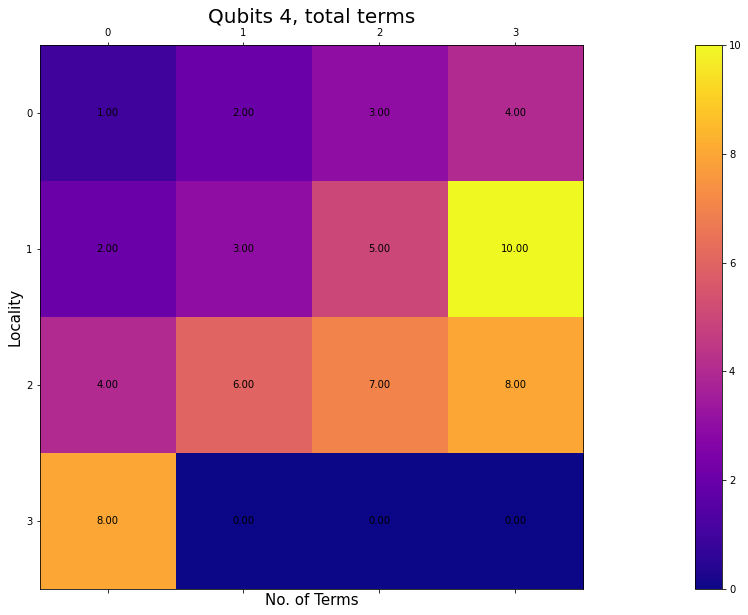

In [12]:
plot_grid(grid,2)